# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

# Load survey data

In [12]:
# Read it in
path = "../data/surveys.xlsx"
survey_32W = pd.read_excel(path, sheet_name="Survey_32W", converters={'T3':str})
survey_32N = pd.read_excel(path, sheet_name="Survey_32N")

# Drop unnecessary columns
survey_32W.drop(columns=['Unnamed: 0', 'subject_id', 'image_name', 'image_name_2'], inplace=True)
survey_32N.drop(columns=['Unnamed: 0', 'subject_id', 'image_name', 'image_name_2'], inplace=True)

# Drop rows missing response
survey_32W = survey_32W[
    (survey_32W['T3'] != ' ') &
    (survey_32W['T3'] != 'none') &
    (survey_32W['T3'].notnull()) &
    (survey_32W['T3'] != 'No Comments ') &
    (survey_32W['T3'] != 0) &
    (survey_32W['T3'] != 'None') &
    (survey_32W['T3'] != '[NO ANSWER]')]

# Select responses
res_together = survey_32W['T3'][survey_32W['T1'] == "['They should be together in the same outfits']"].tolist()
res_separate = survey_32W['T3'][survey_32W['T1'] == "['They should be in separate outfits']"].tolist()

# Define function for comparing responses

In [3]:
def compare_all(idx, res, embed):
    total = 0
    for i in range(len(res)):
        if i == idx:
            continue
        total += np.dot(embed[idx], embed[i])/(np.linalg.norm(embed[idx])*np.linalg.norm(embed[i]))
    return total/(len(res)-1)

# Sentence-BERT

In [4]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWa

## Get embeddings

In [13]:
embed_together = model.encode(res_together)
embed_separate = model.encode(res_separate)

## Compare responses

### Compare responses that answered "same outfit"

0.38636940531730807


(0, 1)

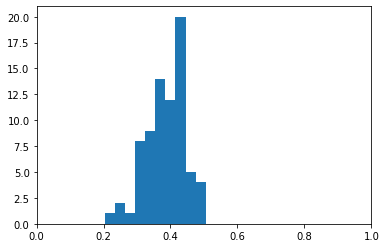

In [14]:
avg_cs_together = [compare_all(idx, res_together, embed_together) for idx in range(len(res_together))]
print(sum(avg_cs_together)/len(res_together))
plt.hist(avg_cs_together)
plt.xlim([0,1])

### Compare responses that said "separate outfits"

0.41017306873676407


(0, 1)

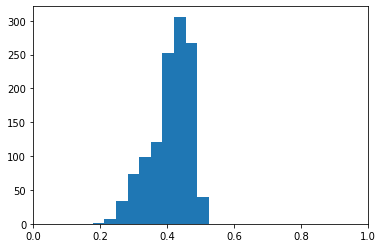

In [15]:
avg_cs_separate = [compare_all(idx, res_separate, embed_separate) for idx in range(len(res_separate))]
print(sum(avg_cs_separate)/len(res_separate))
plt.hist(avg_cs_separate)
plt.xlim([0,1])

### Compare "same outfit" responses to all "separate outfit" responses

0.3625411973380352


(0, 1)

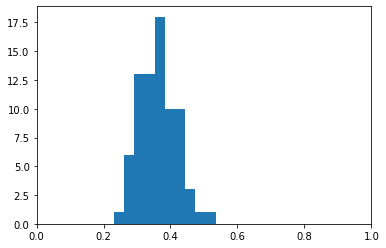

In [16]:
avg_cs_together_v_separate = [
    1 - (sum(scipy.spatial.distance.cdist([embed], embed_separate, "cosine")[0]) / len(embed_separate))
    for embed in embed_together]
print(sum(avg_cs_together_v_separate)/len(res_together))
plt.hist(avg_cs_together_v_separate)
plt.xlim([0,1])

### Compare "separate outfit" responses to all "same outfit" responses

0.3625411973380356


(0, 1)

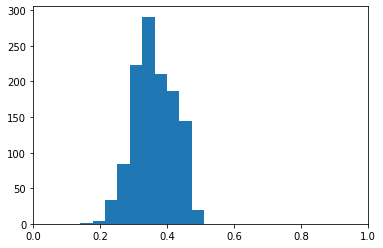

In [17]:
avg_cs_separate_v_together = [
    1 - (sum(scipy.spatial.distance.cdist([embed], embed_together, "cosine")[0]) / len(embed_together))
    for embed in embed_separate]
print(sum(avg_cs_separate_v_together)/len(res_separate))
plt.hist(avg_cs_separate_v_together)
plt.xlim([0,1])

# bert-as-service

In [18]:
from bert_serving.client import BertClient
bc = BertClient()

## Get embeddings

In [19]:
embed_together = bc.encode(res_together)
embed_separate = bc.encode(res_separate)

C:\Users\Savannah\Anaconda3\lib\site-packages\bert_serving\client\__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=50" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


## Compare responses

### Compare responses that answered "same outfit"

0.6920482698762626


(0, 1)

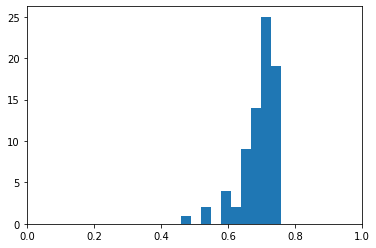

In [20]:
avg_cs_together = [compare_all(idx, res_together, embed_together) for idx in range(len(res_together))]
print(sum(avg_cs_together)/len(res_together))
plt.hist(avg_cs_together)
plt.xlim([0,1])

### Compare responses that said "separate outfits"

0.6831075580363939


(0, 1)

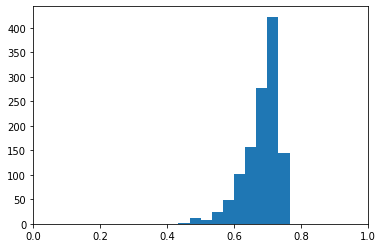

In [21]:
avg_cs_separate = [compare_all(idx, res_separate, embed_separate) for idx in range(len(res_separate))]
print(sum(avg_cs_separate)/len(res_separate))
plt.hist(avg_cs_separate)
plt.xlim([0,1])

### Compare "same outfit" responses to all "separate outfit" responses

0.6822846262211361


(0, 1)

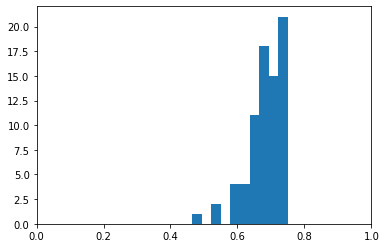

In [22]:
avg_cs_together_v_separate = [
    1 - (sum(scipy.spatial.distance.cdist([embed], embed_separate, "cosine")[0]) / len(embed_separate))
    for embed in embed_together]
print(sum(avg_cs_together_v_separate)/len(res_together))
plt.hist(avg_cs_together_v_separate)
plt.xlim([0,1])

### Compare "separate outfit" responses to all "same outfit" responses

0.682284626221135


(0, 1)

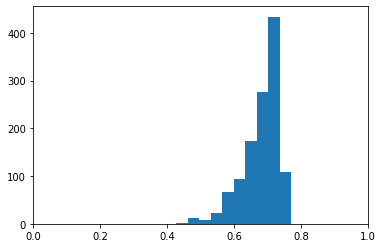

In [23]:
avg_cs_separate_v_together = [
    1 - (sum(scipy.spatial.distance.cdist([embed], embed_together, "cosine")[0]) / len(embed_together))
    for embed in embed_separate]
print(sum(avg_cs_separate_v_together)/len(res_separate))
plt.hist(avg_cs_separate_v_together)
plt.xlim([0,1])